In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_SHOW_CPP_STACKTRACES"]="1"
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.unfolding_flow import UnfoldingFlow

import numpy as np
#import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from collections import defaultdict
from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak
import random
import pandas as pd

from memflow.read_data.utils import to_flat_tensor
#from memflow.phasespace.phasespace import PhaseSpace
#from memflow.phasespace import phasespace_mod

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor


from rich.progress import track

pi = torch.pi

torch.autograd.set_detect_anomaly(True)

In [2]:
batchSize = 1024

device = torch.device("cuda") #torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify the GPU ids

basedir_flow= "/work/dvalsecc/MEM/models_archive/flow_pretrain_labframe_logit/best/best_flow_logit_v2-auto_DiagNormal_NoTransf10_NoBins40_DNN4_256/"
#basedir_flow= "/work/dvalsecc/MEM/models_archive/flow_pretrain_labframe_logit/flow_flow_logit_v11-auto_DiagNormal_NoTransf6_NoBins45_DNN5_256"

model_weights = basedir_flow + '/model_flow_logit_v2-auto.pt'
path_to_conf = basedir_flow + '/config_flow_logit_v2-auto.yaml'

input_dataset_test = '/work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet'

with open(path_to_conf) as f:
        config = OmegaConf.load(path_to_conf)

config

data = DatasetCombined(input_dataset_test, dev=torch.device("cpu"),
                                    dtype=torch.float64, datasets=['partons_lab', 'reco_lab', 'partons_CM'],
                           reco_list_lab=['scaledLogRecoParticles', 'mask_lepton', 
                                      'mask_jets','mask_met',
                                      'mask_boost', 'scaledLogBoost'],
                           parton_list_lab=['logScaled_data_higgs_t_tbar_ISR',
                                        'logScaled_data_boost',
                                        'mean_log_data_higgs_t_tbar_ISR',
                                        'std_log_data_higgs_t_tbar_ISR',
                                        'mean_log_data_boost',
                                            'std_log_data_boost'],
                           parton_list_cm=['phasespace_intermediateParticles_onShell_logit',
                                           'phasespace_intermediateParticles_onShell_logit_scaled',
                                           'phasespace_intermediateParticles_onShell',
                                           'mean_phasespace_intermediateParticles_onShell_logit',
                                            'std_phasespace_intermediateParticles_onShell_logit',
                                          ])



log_mean_parton = data.partons_lab.mean_log_data_higgs_t_tbar_ISR.to(device)
log_std_parton = data.partons_lab.std_log_data_higgs_t_tbar_ISR.to(device)
log_mean_boost = data.partons_lab.mean_log_data_boost.to(device)
log_std_boost = data.partons_lab.std_log_data_boost.to(device)
mean_ps = data.partons_CM.mean_phasespace_intermediateParticles_onShell_logit.to(device)
scale_ps = data.partons_CM.std_phasespace_intermediateParticles_onShell_logit.to(device)

# Initialize model
model = UnfoldingFlow(
                pretrained_model=None,
                load_conditioning_model=False,
                scaling_partons_lab = [log_mean_parton, log_std_parton],
                scaling_boost_lab = [log_mean_boost, log_std_boost],
                scaling_partons_CM_ps = [mean_ps, scale_ps],

                no_jets=config.input_shape.number_jets,
                no_lept=config.input_shape.number_lept,
                input_features=config.input_shape.input_features,
                cond_hiddenFeatures=config.conditioning_transformer.hidden_features,
                cond_dimFeedForward=config.conditioning_transformer.dim_feedforward_transformer,
                cond_outFeatures=config.conditioning_transformer.out_features,
                cond_nheadEncoder=config.conditioning_transformer.nhead_encoder,
                cond_NoLayersEncoder=config.conditioning_transformer.no_layers_encoder,
                cond_nheadDecoder=config.conditioning_transformer.nhead_decoder,
                cond_NoLayersDecoder=config.conditioning_transformer.no_layers_decoder,
                cond_NoDecoders=config.conditioning_transformer.no_decoders,
                cond_aggregate=config.conditioning_transformer.aggregate,
                cond_use_latent=config.conditioning_transformer.use_latent,
                cond_out_features_latent=config.conditioning_transformer.out_features_latent,
                cond_no_layers_decoder_latent=config.conditioning_transformer.no_layers_decoder_latent,   
    
                flow_nfeatures=config.unfolding_flow.nfeatures,
                flow_ncond=config.unfolding_flow.ncond, 
                flow_ntransforms=config.unfolding_flow.ntransforms,
                flow_hiddenMLP_NoLayers=config.unfolding_flow.hiddenMLP_NoLayers, 
                flow_hiddenMLP_LayerDim=config.unfolding_flow.hiddenMLP_LayerDim,
                flow_bins=config.unfolding_flow.bins,
                flow_autoregressive=config.unfolding_flow.autoregressive,
                flow_base=config.unfolding_flow.base,
                flow_base_first_arg=config.unfolding_flow.base_first_arg,
                flow_base_second_arg=config.unfolding_flow.base_second_arg,
                flow_bound=config.unfolding_flow.bound,
                randPerm=config.unfolding_flow.randPerm,
                device=device,
                dtype=torch.float64,
                eps=config.training_params.eps)

model.load_state_dict(torch.load(model_weights, map_location=device)["model_state_dict"])


>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Create new file for partons
Create new file for lepton_partons
Create new file for boost
Create new file for H_thad_tlep_ISR
Create new file for H_thad_tlep_ISR_cartesian
Create flattening weight


/work/dvalsecc/MEM/MEMFlow/memflow/read_data/Dataset_PartonNoBoost_Level.py:507: RuntimeWarning: divide by zero encountered in divide
  (1/ h.values()) * len(higgs)/(Nbins**3),


Create new file for data_higgs_t_tbar_ISR_cartesian_onShell
Create new file for PhaseSpace + rambo detJacobian
Create new file for PhaseSpace_onShell (no negative values)
Create new file for Log_H_thad_tlep_ISR_cartesian
Create new file for Log_H_thad_tlep_ISR
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Load logScaled_data_boost
Parton: Move tensors to device (cpu) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load scaledLogBoost
Load scaledLogRecoParticles
Reco: Move tensors to device (cpu) memory
Loading partons in CM
PartonLevel CM
Create new file for partons
Create new file for lepton_partons
Create new file for boost
Create new file for H_thad_tlep_ISR
Create new file for H_thad_tlep_ISR_cartesian
Create flattening weight


/work/dvalsecc/MEM/MEMFlow/memflow/read_data/Dataset_Parton_Level.py:572: RuntimeWarning: divide by zero encountered in divide
  (1/ h.values()) * len(higgs)/(Nbins**3),


Create new file for data_higgs_t_tbar_ISR_cartesian_onShell
Create new file for PhaseSpace + rambo detJacobian
Create new file for PhaseSpace_onShell (no negative values)
Create new file for Log_H_thad_tlep_ISR_cartesian
Create new file for Log_H_thad_tlep_ISR
Reading parton_level Files
Load phasespace_intermediateParticles_onShell
Load phasespace_intermediateParticles_onShell_logit
Parton: Move tensors to device (cpu) memory
Loaded datasets:  ['partons_lab', 'reco_lab', 'partons_CM']


<All keys matched successfully>

In [3]:
E_CM = 13000
#phasespace = PhaseSpace(E_CM, [21,21], [25,6,-6,21], dev="cpu")


dataCM = data.partons_CM.data_higgs_t_tbar_ISR_cartesian
dataLab = data.partons_lab.data_higgs_t_tbar_ISR_cartesian
PS_target = data.partons_CM.phasespace_intermediateParticles_onShell
boost_parton = data.partons_CM.data_boost

higgsCorrect = vector.array(
    {
        "E": dataCM[:,0,0].detach().cpu().numpy(),
        "px": dataCM[:,0,1].detach().cpu().numpy(),
        "py": dataCM[:,0,2].detach().cpu().numpy(),
        "pz": dataCM[:,0,3].detach().cpu().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCM[:,1,0].detach().cpu().numpy(),
        "px": dataCM[:,1,1].detach().cpu().numpy(),
        "py": dataCM[:,1,2].detach().cpu().numpy(),
        "pz": dataCM[:,1,3].detach().cpu().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCM[:,2,0].detach().cpu().numpy(),
        "px": dataCM[:,2,1].detach().cpu().numpy(),
        "py": dataCM[:,2,2].detach().cpu().numpy(),
        "pz": dataCM[:,2,3].detach().cpu().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCM[:,3,0].detach().cpu().numpy(),
        "px": dataCM[:,3,1].detach().cpu().numpy(),
        "py": dataCM[:,3,2].detach().cpu().numpy(),
        "pz": dataCM[:,3,3].detach().cpu().numpy(),
    }
)

# In the lab
higgsCorrect_lab = vector.array(
    {
        "E": dataLab[:,0,0].detach().cpu().numpy(),
        "px": dataLab[:,0,1].detach().cpu().numpy(),
        "py": dataLab[:,0,2].detach().cpu().numpy(),
        "pz": dataLab[:,0,3].detach().cpu().numpy(),
    }
)

thadCorrect_lab = vector.array(
    {
        "E": dataLab[:,1,0].detach().cpu().numpy(),
        "px": dataLab[:,1,1].detach().cpu().numpy(),
        "py": dataLab[:,1,2].detach().cpu().numpy(),
        "pz": dataLab[:,1,3].detach().cpu().numpy(),
    }
)

tlepCorrect_lab = vector.array(
    {
        "E": dataLab[:,2,0].detach().cpu().numpy(),
        "px": dataLab[:,2,1].detach().cpu().numpy(),
        "py": dataLab[:,2,2].detach().cpu().numpy(),
        "pz": dataLab[:,2,3].detach().cpu().numpy(),
    }
)

glISRCorrect_lab = vector.array(
    {
        "E": dataLab[:,3,0].detach().cpu().numpy(),
        "px": dataLab[:,3,1].detach().cpu().numpy(),
        "py": dataLab[:,3,2].detach().cpu().numpy(),
        "pz": dataLab[:,3,3].detach().cpu().numpy(),
    }
)

higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")

higgsCorrect_lab = ak.with_name(higgsCorrect_lab, name="Momentum4D")
thadCorrect_lab = ak.with_name(thadCorrect_lab, name="Momentum4D")
tlepCorrect_lab = ak.with_name(tlepCorrect_lab, name="Momentum4D")
glISRCorrect_lab = ak.with_name(glISRCorrect_lab, name="Momentum4D")

In [40]:
indices = list(range(50))
logScaled_reco = data.reco_lab.scaledLogRecoParticles[indices].to(device)
mask_lepton_reco = data.reco_lab.mask_lepton[indices].to(device)
mask_jets = data.reco_lab.mask_jets[indices].to(device)
mask_met = data.reco_lab.mask_met[indices].to(device)
mask_boost_reco = data.reco_lab.mask_boost[indices].to(device)
data_boost_reco = data.reco_lab.scaledLogBoost[indices].to(device)

boost_parton = data.partons_CM.data_boost[indices].to(device)
parton_cartesian = data.partons_CM.data_higgs_t_tbar_ISR_cartesian_onShell[indices].to(device)
ps_target_scaled = data.partons_CM.phasespace_intermediateParticles_onShell_logit_scaled[indices].to(device)
ps_target = data.partons_CM.phasespace_intermediateParticles_onShell[indices].to(device)
ps_target_logit = data.partons_CM.phasespace_intermediateParticles_onShell[indices].to(device)

In [41]:
model = model.to(device)

In [42]:
mask_recoParticles = torch.cat((mask_jets, mask_lepton_reco, mask_met), dim=1)
if True : # Always remove true proveance TODO REMOVE THE HACK 
    logScaled_reco = logScaled_reco[:,:,:-1]


# The provenance is remove in the model
(data_regressed, data_regressed_cm, ps_regr,
     logit_ps_regr, flow_cond_vector,
     flow_logprob, mask_problematic)   = model(logScaled_reco,
                                                  data_boost_reco,
                                                  mask_recoParticles,
                                                  mask_boost_reco,
                                                  ps_target_scaled,
                                                  disableGradConditioning=False,
                                                  flow_eval="normalizing")
#ps_samples = model.flow(flow_cond_vector).sample((1024,))

In [43]:
flow_logprob

tensor([ 9.6904, 23.0132, 13.2637,  6.0112,  4.5460, 21.3109,  7.1442, 17.5068,
        11.7217, 10.3508, -1.6495,  8.7515, 15.8730,  8.4007,  8.5149, 17.9340,
        18.4631, 12.5039, 16.8586, 20.2902,  8.5944, 11.3144,  6.6615,  7.3501,
        23.4463,  6.7524, 10.9470,  1.7930, 14.1132, 14.7665,  9.2050, 13.4462,
        10.2072,  6.6809, 12.2203, 13.0260, 14.9817, 19.3299, 12.4001,  2.8598,
        11.2883, 13.9727, 18.0793,  5.2816,  6.2081, 16.0641,  6.3373, 17.2890,
         7.4706,  6.0465], device='cuda:0', grad_fn=<AddBackward0>)

In [44]:
loss_prob = - flow_logprob.nanmean()

In [34]:
loss_prob.backward()

In [11]:
pp =  dict(model.named_parameters())    

In [12]:
pp["cond_transformer.transformer_encoder.layers.0.linear1.weight"].grad

tensor([[-2.3255e-03,  1.0268e-02,  2.6622e-03,  ..., -2.5346e-02,
         -2.4345e-03,  4.8535e-02],
        [-1.0545e-01,  4.5569e-02,  4.4881e-02,  ...,  7.1757e-02,
          8.0468e-02, -2.1216e-01],
        [ 1.9053e-03, -2.4694e-02, -3.3303e-02,  ..., -3.0990e-04,
         -4.0826e-02,  1.7351e-01],
        ...,
        [ 8.1613e-02,  3.2727e-02, -3.3836e-02,  ..., -1.0616e-01,
         -6.2040e-02,  1.1726e-01],
        [ 1.7856e-02,  5.8827e-03,  1.2050e-02,  ...,  5.5358e-03,
         -6.3259e-03, -5.6733e-02],
        [ 8.1954e-03,  2.9568e-03, -2.7341e-05,  ...,  1.2572e-02,
          8.8040e-03, -7.4536e-02]], device='cuda:0')

In [52]:
loss_prob

tensor(-11.4820, device='cuda:0', grad_fn=<NegBackward0>)

In [14]:
loss.backward()

In [23]:
# At the same time we also sample

In [45]:
ps_samples = model.flow(flow_cond_vector).rsample((1,))
ps_samples = ps_samples.squeeze()
ps_new = torch.sigmoid(ps_samples*scale_ps + mean_ps)

In [46]:
import memflow.phasespace as phas
phasespace = phas.phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6,21], dev="cuda")

In [47]:
momenta, weight, x1, x2 = phasespace.get_momenta_from_ps(ps_new, requires_grad=True)

In [11]:
weight

tensor([2.6615e+00, 6.9866e+04, 1.2256e+03, 1.3262e+01, 9.8108e+00, 3.4177e+04,
        3.0967e+03, 6.4142e+03, 1.3959e+02, 1.0976e+04, 1.0039e+01, 6.2610e+02,
        1.4068e+03, 8.9640e+02, 7.6615e+03, 1.3261e+04, 7.8206e+05, 5.0307e+03,
        4.7871e+02, 3.1221e+02, 1.6646e+03, 1.9530e+04, 2.4507e+05, 1.3224e+04,
        1.8154e+04, 3.1818e+03, 3.3033e+04, 1.3681e+05, 3.9422e+06, 2.6149e+04,
        1.3089e+00, 1.2047e+04, 2.6675e+02, 2.5515e+03, 6.7131e+01, 5.1482e+01,
        1.4578e+03, 4.1518e+03, 2.5349e+03, 1.8537e+02, 1.9113e+03, 7.6210e+01,
        1.5742e+05, 3.5681e+03, 6.5982e+02, 3.1869e+02, 1.1221e+02, 1.3386e+06,
        7.7306e+02, 5.3353e+03], device='cuda:0', grad_fn=<MulBackward0>)

In [48]:
(loss_prob + momenta[:,0,0].mean()).backward()

In [49]:
pp["cond_transformer.transformer_encoder.layers.3.linear1.weight"].grad

tensor([[ 0.1732, -0.0169,  0.2564,  ..., -0.2148,  0.1927, -1.3978],
        [ 5.3129, -2.0609,  2.1267,  ..., -9.1207, -4.5678,  6.6388],
        [-1.1046, -1.2949, -4.5089,  ...,  4.7607, -4.2598,  8.8477],
        ...,
        [ 0.0890,  0.2842,  1.6657,  ..., -1.2250,  1.2432, -4.0052],
        [ 0.0893, -0.5387, -0.5566,  ..., -0.1202, -1.0441,  0.8124],
        [ 0.0268,  0.0223, -0.0120,  ...,  0.0264,  0.0163, -0.1882]],
       device='cuda:0')

In [17]:
loss = (momenta[:, 2, 0]).mean()

In [18]:
loss

tensor(236.8525, device='cuda:0')

(array([29., 43., 44., 28., 44., 32., 29., 22., 20., 19., 25., 22., 17.,
        16., 14., 11., 11.,  8.,  7.,  9.,  4.,  5.,  5.,  5.,  3.,  1.,
         4.,  3.,  1.,  1.,  1.,  6.,  0.,  3.,  4.,  3.,  1.,  0.,  1.,
         2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 127.16903273,  137.66211669,  148.15520065,  158.64828461,
         169.14136857,  179.63445253,  190.12753649,  200.62062045,
         211.1137044 ,  221.60678836,  232.09987232,  242.59295628,
         253.08604024,  263.5791242 ,  274.07220816,  284.56529212,
         295.05837608,  305.55146004,  316.044544  ,  326.53762795,
         337.03071191,  347.52379587,  358.01687983,  368.50996379,
         379.00304775,  38

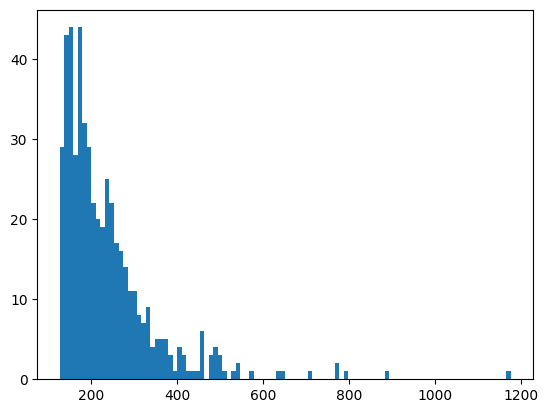

In [25]:
plt.hist(momenta[:,2,0 ].detach().cpu().numpy(), bins=100)

# Minimal rambo PS --> particle, differentiable

In [5]:
import memflow.phasespace as phas
phasespace = phas.phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6,21], dev="cpu")

In [7]:
phasespace.get_momenta_from_ps(ps_target.to("cpu"), requires_grad=False)

tensor([[0.6153, 0.0801],
        [0.8385, 0.0021],
        [0.6520, 0.0435],
        [0.5161, 0.7610],
        [0.8197, 0.3592],
        [0.3867, 0.2512],
        [0.8061, 0.3981],
        [0.0847, 0.7737],
        [0.2110, 0.2099],
        [0.6954, 0.1067],
        [0.6394, 0.8096],
        [0.8678, 0.5706],
        [0.4870, 0.7250],
        [0.9816, 0.2179],
        [0.5022, 0.0370],
        [0.5631, 0.0179],
        [0.9398, 0.0261],
        [0.0125, 0.0491],
        [0.7507, 0.1510],
        [0.2981, 0.5502],
        [0.3766, 0.0813],
        [0.9892, 0.2396],
        [0.8093, 0.7054],
        [0.2329, 0.2026],
        [0.3723, 0.2186],
        [0.9264, 0.2702],
        [0.9631, 0.5775],
        [0.9413, 0.3438],
        [0.3948, 0.3431],
        [0.8843, 0.0465],
        [0.6982, 0.2962],
        [0.8208, 0.1740],
        [0.2578, 0.0311],
        [0.8212, 0.6341],
        [0.5227, 0.2666],
        [0.3582, 0.4434],
        [0.1988, 0.6918],
        [0.4456, 0.2995],
        [0.6

(tensor([[[ 2.8922e+02,  0.0000e+00,  0.0000e+00,  2.8922e+02],
          [ 2.8922e+02,  0.0000e+00,  0.0000e+00, -2.8922e+02],
          [ 1.5636e+02, -4.5710e+01, -7.1108e+01, -4.0194e+01],
          [ 2.0516e+02,  5.2303e+01, -4.3440e+01,  8.7815e+01],
          [ 2.0941e+02, -8.2587e+00,  1.1105e+02, -4.1175e+01],
          [ 7.5207e+00,  1.6656e+00,  3.4988e+00, -6.4455e+00]],
 
         [[ 5.3972e+02,  0.0000e+00,  0.0000e+00,  5.3972e+02],
          [ 5.3972e+02,  0.0000e+00,  0.0000e+00, -5.3972e+02],
          [ 2.0775e+02,  1.0554e+02,  1.2587e+02,  2.2105e+01],
          [ 4.8054e+02,  3.3520e+01, -4.2235e+02, -1.4717e+02],
          [ 3.9058e+02, -1.3953e+02,  2.9613e+02,  1.2503e+02],
          [ 5.8171e-01,  4.6433e-01,  3.4812e-01,  3.9947e-02]],
 
         [[ 3.0168e+02,  0.0000e+00,  0.0000e+00,  3.0168e+02],
          [ 3.0168e+02,  0.0000e+00,  0.0000e+00, -3.0168e+02],
          [ 1.6018e+02,  3.4649e+01,  8.3249e+01,  4.2872e+01],
          [ 2.3421e+02,  5.9491e+0

In [10]:
ps, det = phasespace.get_ps_from_momenta( momenta_original[:,2:], x1, x2)
momenta2, w2, x1_2, x2_2 = phasespace.get_momenta_from_ps(ps, requires_grad=False)

NameError: name 'momenta_original' is not defined

In [16]:
ps_new[0:10]

tensor([[7.2403e-01, 6.2960e-01, 5.4712e-03, 5.8954e-01, 1.1799e-02, 9.3013e-01,
         4.2256e-03, 3.5464e-01, 5.1755e-01, 4.9916e-01],
        [8.8830e-01, 3.7289e-01, 5.6947e-01, 1.2461e-01, 4.1116e-01, 7.9773e-01,
         7.0223e-01, 3.0087e-01, 4.5267e-01, 6.5039e-01],
        [8.7044e-01, 2.1787e-01, 6.1181e-01, 1.2084e-01, 1.6670e-01, 5.8264e-01,
         6.4712e-01, 1.1233e-01, 4.8309e-01, 8.6867e-01],
        [8.5308e-01, 6.0578e-01, 4.4914e-01, 6.8941e-01, 6.9473e-01, 5.6003e-01,
         9.7224e-01, 1.1248e-01, 7.8703e-01, 7.9103e-01],
        [1.8876e-01, 2.0233e-01, 3.1497e-01, 2.6004e-01, 9.8268e-01, 7.5239e-01,
         7.6868e-02, 9.5269e-01, 7.8003e-01, 8.6184e-01],
        [6.4711e-01, 5.4814e-01, 1.7310e-01, 7.4355e-01, 7.6650e-01, 5.9842e-01,
         8.9935e-01, 7.3912e-02, 5.2772e-01, 6.1270e-01],
        [2.4138e-01, 8.1281e-01, 7.7817e-01, 2.0851e-01, 2.4693e-01, 7.2074e-01,
         9.5644e-01, 4.6784e-01, 8.4791e-01, 5.1081e-01],
        [8.0808e-04, 7.3385

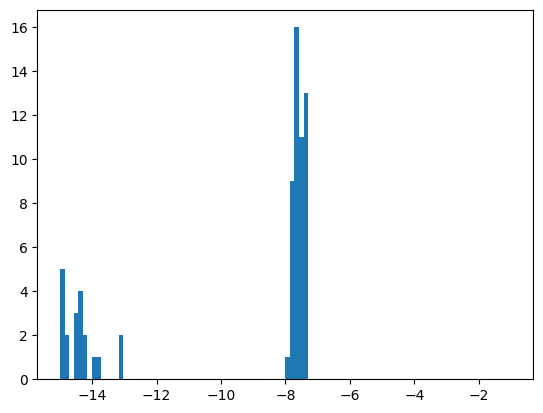

In [22]:
plt.hist(torch.log10((ps-ps_new).abs()).flatten().detach().cpu().numpy(), range=(-15,-1), bins=100);

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          2.,   5.,   7.,  11.,  18.,  20.,  38.,  52.,  84.,  87., 139.,
        132.,  90.,  66.,  86.,  21.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-14.  , -13.74, -13.48, -13.22, -12.96, -12.7 , -12.44, -12.18,
        -11.92, -11.66, -11.4 , -11.14, -10.88, -10.62, -10.36, -10.1 ,
         -9.84,  -9.58,  -9.32,  -9.06,  -8.8 ,  -8.54,  -8.28,  -8.02,
         -7.76,  -7.5 ,  -7.24,  -6.98,  -6.72,  -6.46,  -6.2 ,  -5.94,
         -5.68,  -5.42,  -5.16,  -4.9 ,  -4.64,  -4.38,  -4.12,  -3.86,
         -3.6 ,  -3.34,  -3.08,  -2.82,  -2.56,  -2.3 ,  -2.04,  -1.78,
         -1.52,  -1.26,  -1.  ]),
 <BarContainer object of 50 artists>)

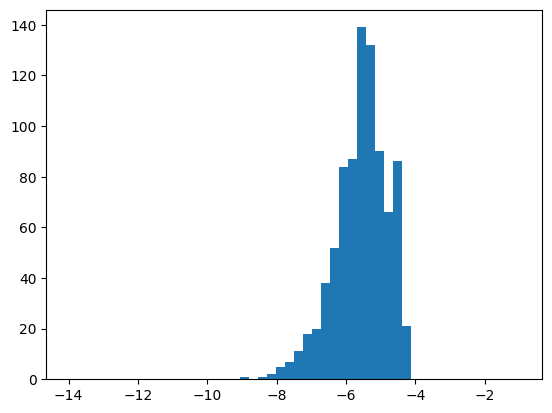

In [30]:
plt.hist(torch.log10((momenta - momenta2).abs()).flatten().detach().cpu().numpy(), bins=50, range=(-14, -1))

tensor([[[ 746.1052,    0.0000,    0.0000,  746.1052],
         [ 746.1052,    0.0000,    0.0000, -746.1052],
         [ 407.1047,  -48.3384,  -30.4826, -383.1199],
         [ 316.5308,   93.8346,  -25.1833, -246.9744],
         [ 185.7924,  -31.0314,   39.0065,   47.7296],
         [ 582.7825,  -14.4648,   16.6594,  582.3647]],

        [[ 554.8355,    0.0000,    0.0000,  554.8355],
         [ 554.8355,    0.0000,    0.0000, -554.8355],
         [ 235.2217,  139.7626,  139.0786,   27.6629],
         [ 448.6156,   35.6823, -405.2854,  -77.2676],
         [ 387.6537, -169.1756,  293.6117,   75.4382],
         [  38.1800,   -6.2692,  -27.4050,  -25.8336]],

        [[ 321.6725,    0.0000,    0.0000,  321.6725],
         [ 321.6725,    0.0000,    0.0000, -321.6725],
         [ 155.4926,   65.1439,   61.8232,   20.6046],
         [ 263.9096, -135.5665,  -90.1413, -115.7078],
         [ 213.8888,   76.9742,   35.8185,   93.7240],
         [  10.0539,   -6.5515,   -7.5004,    1.3792]]], devi

In [51]:
u = torch.tensor([2,3,4]).repeat(2,1)
#u = torch.cat(1

In [52]:
u = torch.cat((torch.ones(u.shape[0], 1),u), dim=1)

In [53]:
u

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.]])

In [56]:
torch.cumprod(u, 1)

tensor([[ 1.,  2.,  6., 24.],
        [ 1.,  2.,  6., 24.]])